In [1]:
#import sys
#sys.path.insert(0,"/workspace/bt")

import yfinance as yf
import matplotlib.pyplot as plt
from strategy import *

%matplotlib inline

bt version :  (0, 2, 9)


In [2]:
tickers = ['TQQQ','TMF']
dualtickers = ['BND','BIL']

# 월초 리밸런싱
run_on_end_of_period = False
# 지연시간 1일, 하루전 종가 기준으로 리밸런싱
lag = 1
resample_monthly = False


In [3]:
data = yf.download(tickers+dualtickers)['Adj Close']
data = data[tickers+dualtickers]
for c in data.columns:
    print(c, data[c].first_valid_index())
assets = data.dropna().copy()

if resample_monthly:
    assets = assets.resample('M').last().dropna()
    lag = 0
    
start_day = assets.index.min() + pd.DateOffset(months=12) - pd.DateOffset(days=1)
print('asset \n', assets)
print('start day : ', start_day)

[*********************100%***********************]  4 of 4 completed
TQQQ 2010-02-11 00:00:00
TMF 2009-04-16 00:00:00
BND 2007-04-10 00:00:00
BIL 2007-05-30 00:00:00
asset 
                  TQQQ        TMF        BND        BIL
Date                                                  
2010-02-11   0.431471   6.695426  55.449608  86.559998
2010-02-12   0.433238   6.771188  55.526707  86.559998
2010-02-16   0.450019   6.831800  55.596828  86.559998
2010-02-17   0.457656   6.613165  55.470665  86.503387
2010-02-18   0.466332   6.500601  55.393600  86.541153
...               ...        ...        ...        ...
2022-12-02  23.410000   9.610000  73.500000  91.440002
2022-12-05  22.230000   9.230000  72.919998  91.449997
2022-12-06  20.820000   9.590000  73.160004  91.480003
2022-12-07  20.570000  10.230000  73.800003  91.480003
2022-12-08  21.299999  10.160000  73.589996  91.540001

[3230 rows x 4 columns]
start day :  2011-02-10 00:00:00


In [4]:
# 매수&보유 백테스트
def long_only_ew(assets, start_day, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

Stat                 benchmark(TQQQ)
-------------------  -----------------
Start                2011-02-10
End                  2022-12-08
Risk-free rate       0.00%

Total Return         2209.77%
Daily Sharpe         0.74
Daily Sortino        1.16
CAGR                 30.41%
Max Drawdown         -80.64%
Calmar Ratio         0.38

MTD                  -9.59%
3m                   -24.09%
6m                   -34.76%
YTD                  -74.39%
1Y                   -74.91%
3Y (ann.)            3.72%
5Y (ann.)            13.57%
10Y (ann.)           35.00%
Since Incep. (ann.)  30.41%

Daily Sharpe         0.74
Daily Sortino        1.16
Daily Mean (ann.)    46.12%
Daily Vol (ann.)     62.02%
Daily Skew           -0.40
Daily Kurt           6.39
Best Day             26.99%
Worst Day            -34.47%

Monthly Sharpe       0.77
Monthly Sortino      1.45
Monthly Mean (ann.)  41.24%
Monthly Vol (ann.)   53.28%
Monthly Skew         -0.14
Monthly Kurt         0.28
Best Month           46.45%
Wo

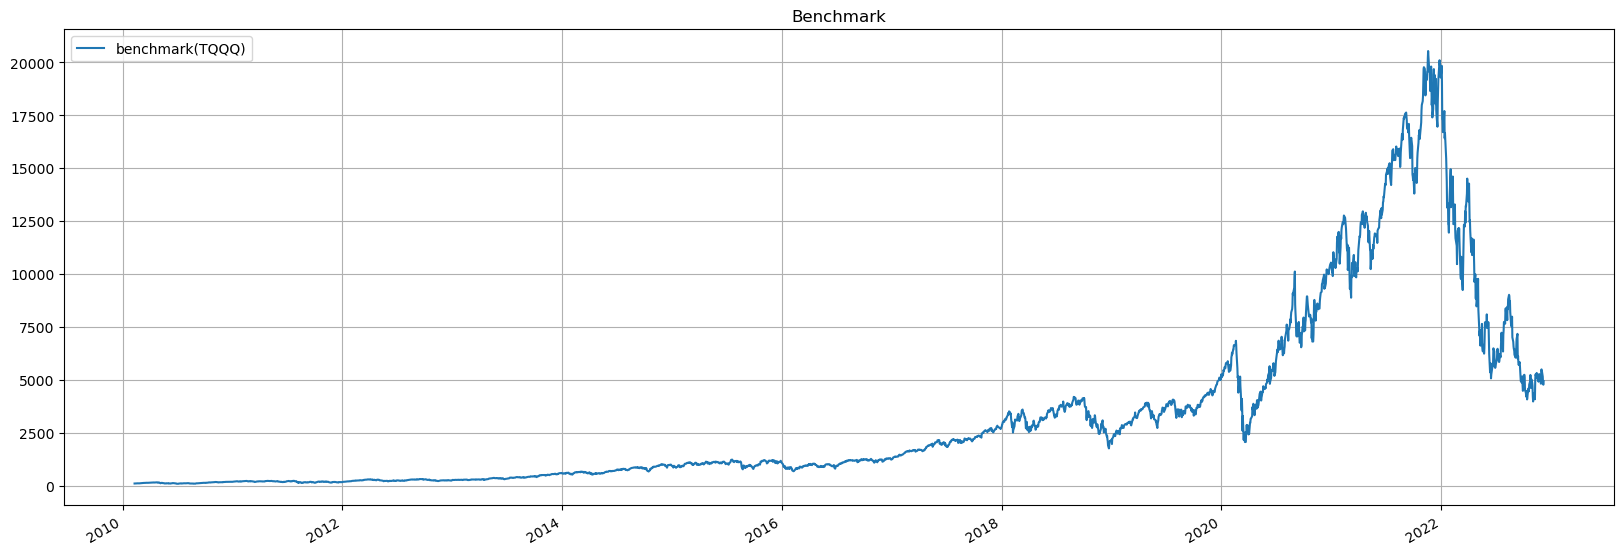

In [5]:
# 벤치마크 수익율
benchmark = long_only_ew(assets[tickers[0]].to_frame(), start_day, 'benchmark({})'.format(tickers[0]))
report = bt.run(benchmark)

report.plot(figsize=(20,7), grid=True, title="Benchmark")
print(report.prices[start_day:].calc_stats().display())

In [6]:
# 상대모멘텀 백테스트
def RelativeMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Relative Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectRelativeMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [7]:
# 상대모멘텀 상위 1종목 (1~12개월 비교)
relativemomentum = {}
for i in range(0, 12):
    relativemomentum[i] = RelativeMomentum_BT(assets[tickers], 1, i+1, start_day, False, lag, name='RM({})'.format(str(i+1)))
    
rm1_report = bt.run(*relativemomentum.values())

<AxesSubplot:title={'center':'Relative Momentum (1~12 month) with rank 1'}>

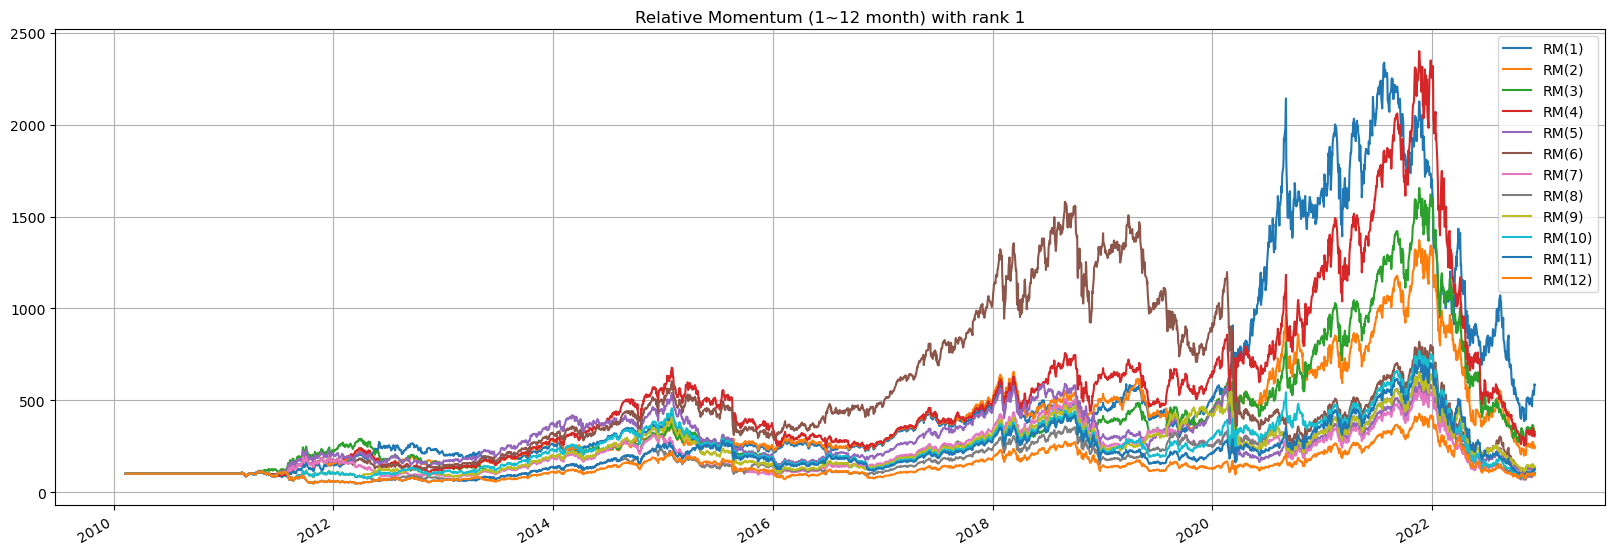

In [8]:
rm1_report.plot(figsize=(20,7), grid=True, title="Relative Momentum (1~12 month) with rank 1")

In [9]:
print(rm1_report.prices[start_day:].calc_stats().display())

Stat                 RM(1)       RM(2)       RM(3)       RM(4)       RM(5)       RM(6)       RM(7)       RM(8)       RM(9)       RM(10)      RM(11)      RM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         483.40%     146.05%     229.43%     213.21%     21.19%      35.39%      0.20%       4.07%       36.80%      -3.34%      25.75%      -6.09%
Daily Sharpe         0.55   

In [10]:
# 절대모멘텀 백테스트
def AbsoluteMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Absolute Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectAbsoluteMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [11]:
# 절대모멘텀 상위 1종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):   
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 1, i+1, start_day, False, lag, name='AM({})'.format(str(i+1)))
    
am1_report = bt.run(*absolutemomentum.values())

<AxesSubplot:title={'center':'Absolute Momentum(1~12 months) with rank 1'}>

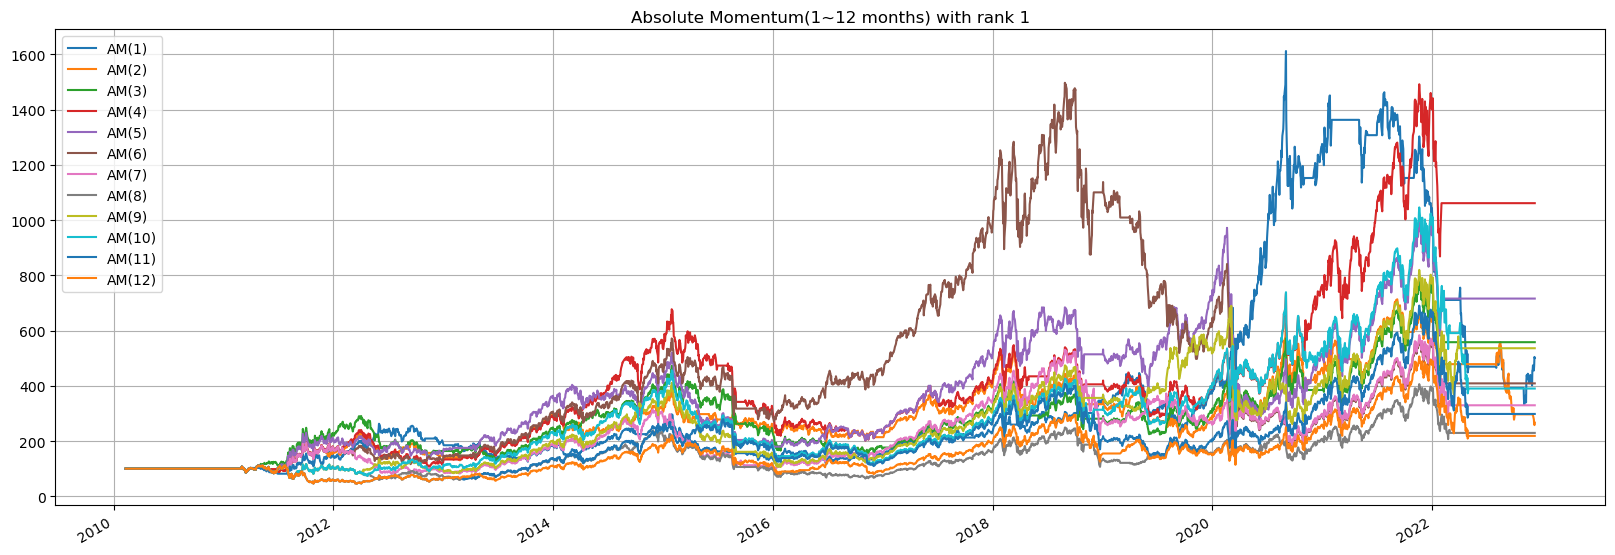

In [12]:
am1_report.plot(figsize=(20,7), grid=True, title='Absolute Momentum(1~12 months) with rank 1')

In [13]:
print(am1_report.prices[start_day:].calc_stats().display())

Stat                 AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         401.29%     166.84%     458.03%     961.31%     615.92%     308.90%     229.57%     129.51%     436.13%     290.18%     198.17%     118.73%
Daily Sharpe         0.53  

In [14]:
# 절대모멘텀 상위 2종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 2, i+1, start_day, False, lag, name='AM({})'.format(str(i+1)))
    
am2_report = bt.run(*absolutemomentum.values())

<AxesSubplot:title={'center':'Absolute Momentum (1~12 month) with rank 2'}>

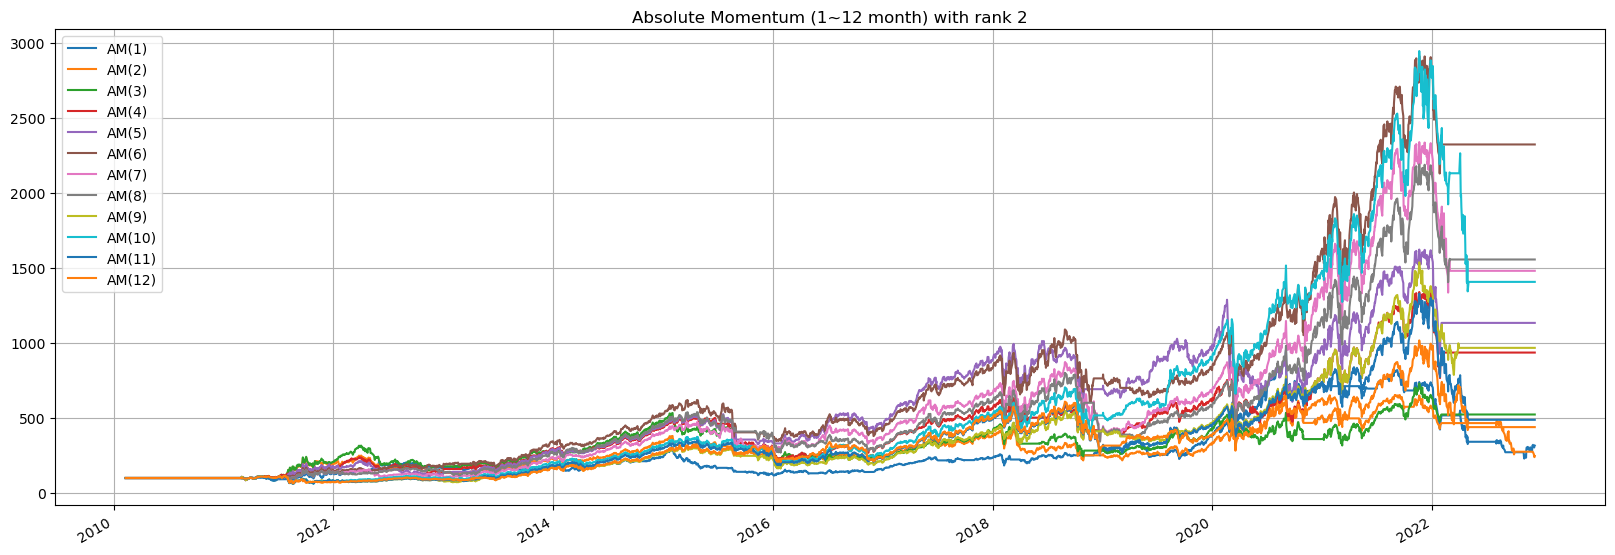

In [15]:
am2_report.plot(figsize=(20,7), grid=True, title='Absolute Momentum (1~12 month) with rank 2')

In [16]:
print(am2_report.prices[start_day:].calc_stats().display())

Stat                 AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         216.21%     147.46%     423.27%     835.98%     1033.71%    2222.80%    1380.74%    1456.28%    867.39%     1307.03%    387.87%     339.21%
Daily Sharpe         0.44  

In [17]:
# 듀얼모멘텀 백테스트
def DualMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Dual Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectDualMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [18]:
# 듀얼모멘텀 상위 1종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    dualmomentums[i] = DualMomentum_BT(assets, 1, i+1, start_day, False, lag, name='ODM({})'.format(str(i+1)))

dm1_report = bt.run(*dualmomentums.values())

<AxesSubplot:title={'center':'Dual Momentum (1~12 months) with rank 1'}>

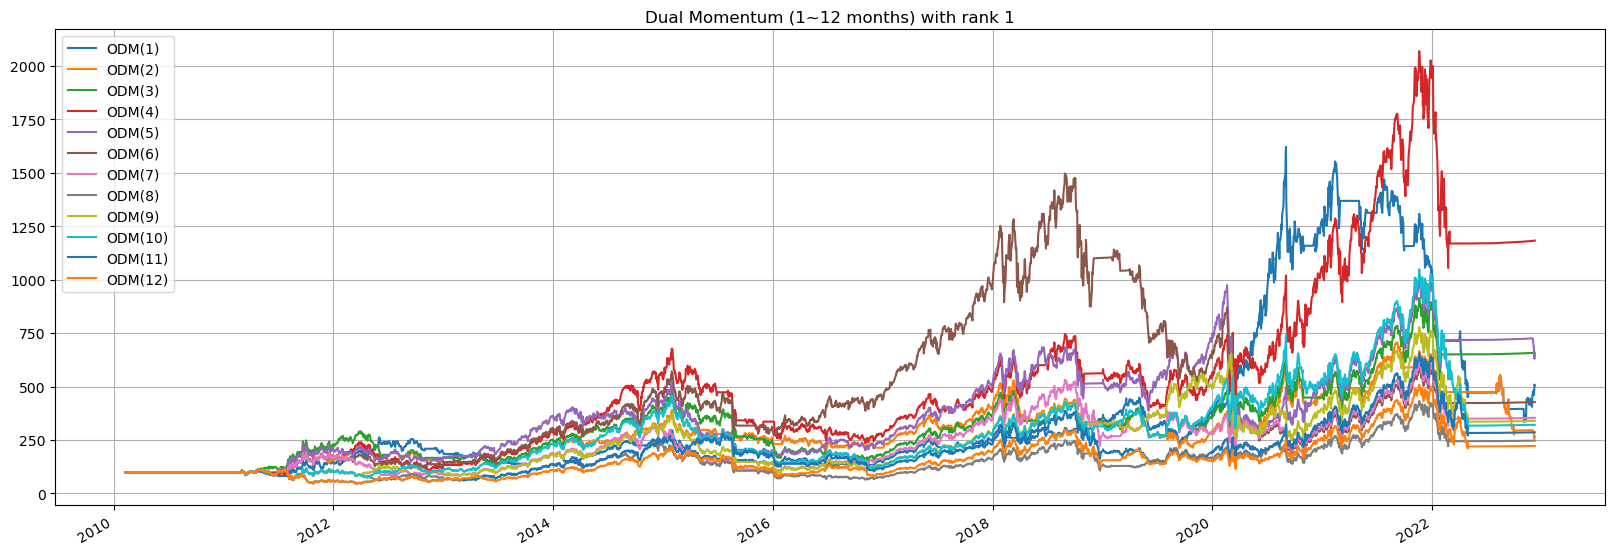

In [19]:
dm1_report.plot(figsize=(20,7), grid=True, title='Dual Momentum (1~12 months) with rank 1')

In [20]:
print(dm1_report.prices[start_day:].calc_stats().display())

Stat                 ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         405.72%     166.27%     557.96%     1082.42%    552.06%     327.65%     253.91%     147.25%     239.66%     220.88%     186.17%     122.25%
Daily Sharpe         0.53 

In [21]:
# 듀얼모멘텀 상위 2종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    dualmomentums[i] = DualMomentum_BT(assets, 2, i+1, start_day, False, lag, name='ODM({})'.format(str(i+1)))

dm2_report = bt.run(*dualmomentums.values())

<AxesSubplot:title={'center':'Dual Momentum (1~12 months) with rank 2'}>

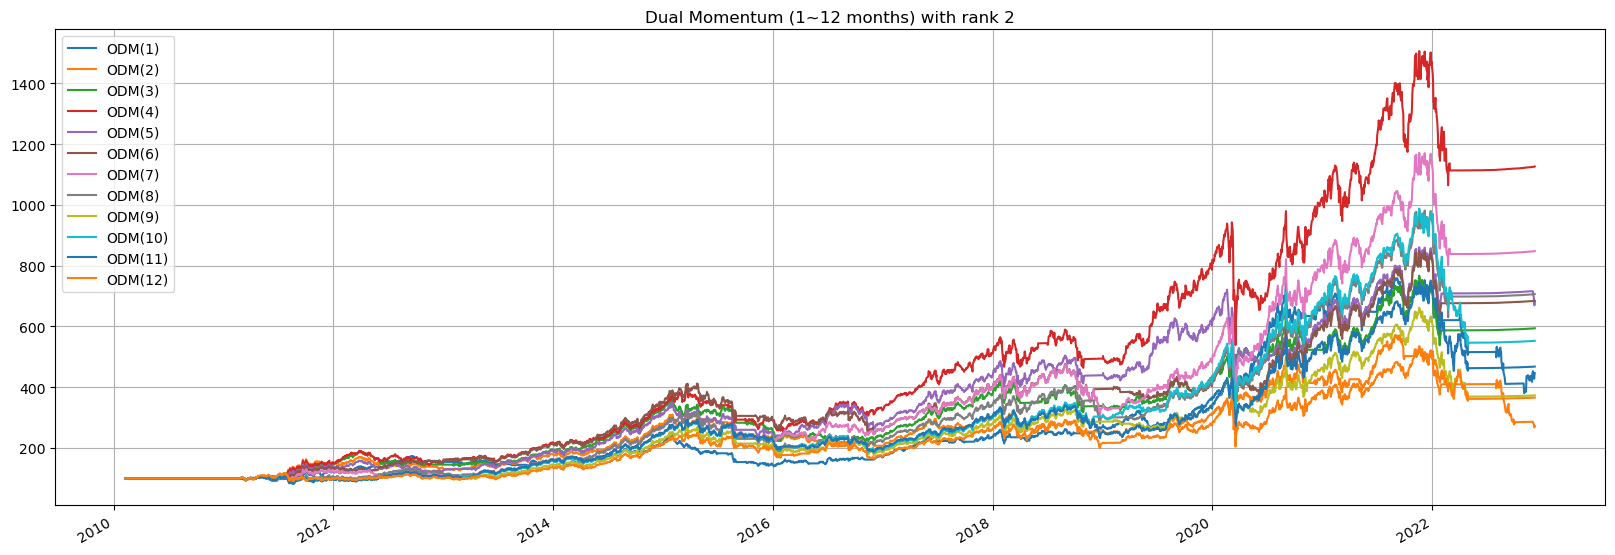

In [22]:
dm2_report.plot(figsize=(20,7), grid=True, title='Dual Momentum (1~12 months) with rank 2')

In [23]:
print(dm2_report.prices[start_day:].calc_stats().display())

Stat                 ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         345.86%     171.89%     493.96%     1026.54%    580.50%     584.43%     748.19%     606.43%     273.07%     452.63%     367.88%     265.63%
Daily Sharpe         0.65 

In [4]:
assets_cash = assets[tickers].copy()
# 1년을 252 영업일로 가정
assets_cash['cash'] = pow(1.03, 1/252)
assets_cash['cash'] = assets_cash['cash'].shift(1, fill_value=1.0)
assets_cash['cash'] = assets_cash['cash'].cumprod()
print(assets_cash)

                 TQQQ        TMF      cash
Date                                      
2010-02-11   0.431471   6.695426  1.000000
2010-02-12   0.433238   6.771188  1.000117
2010-02-16   0.450019   6.831800  1.000235
2010-02-17   0.457656   6.613165  1.000352
2010-02-18   0.466332   6.500601  1.000469
...               ...        ...       ...
2022-12-02  23.410000   9.610000  1.459775
2022-12-05  22.230000   9.230000  1.459946
2022-12-06  20.820000   9.590000  1.460117
2022-12-07  20.570000  10.230000  1.460289
2022-12-08  21.299999  10.160000  1.460460

[3230 rows x 3 columns]


In [5]:
# 평균모멘텀 스코어 백테스트
def AverageMomentum_BT(assets, months, start_day, run_on_end_of_period=False, lag=1, cash_weight=0, name='Average Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighAMSwithCash(lookback=months, lag=lag, cash_weight=cash_weight),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [6]:
# 평균모멘텀 
averagemomentums = {}
cash_weights = [0, 0.3, 0.6]
for i in range(0, len(cash_weights)):
    averagemomentums[i] = AverageMomentum_BT(assets_cash, 12, start_day, False, lag, cash_weights[i], 'AMS_CASH({})'.format(cash_weights[i]))
    
avg_report = bt.run(*averagemomentums.values())

<AxesSubplot:title={'center':'Average Momentum'}>

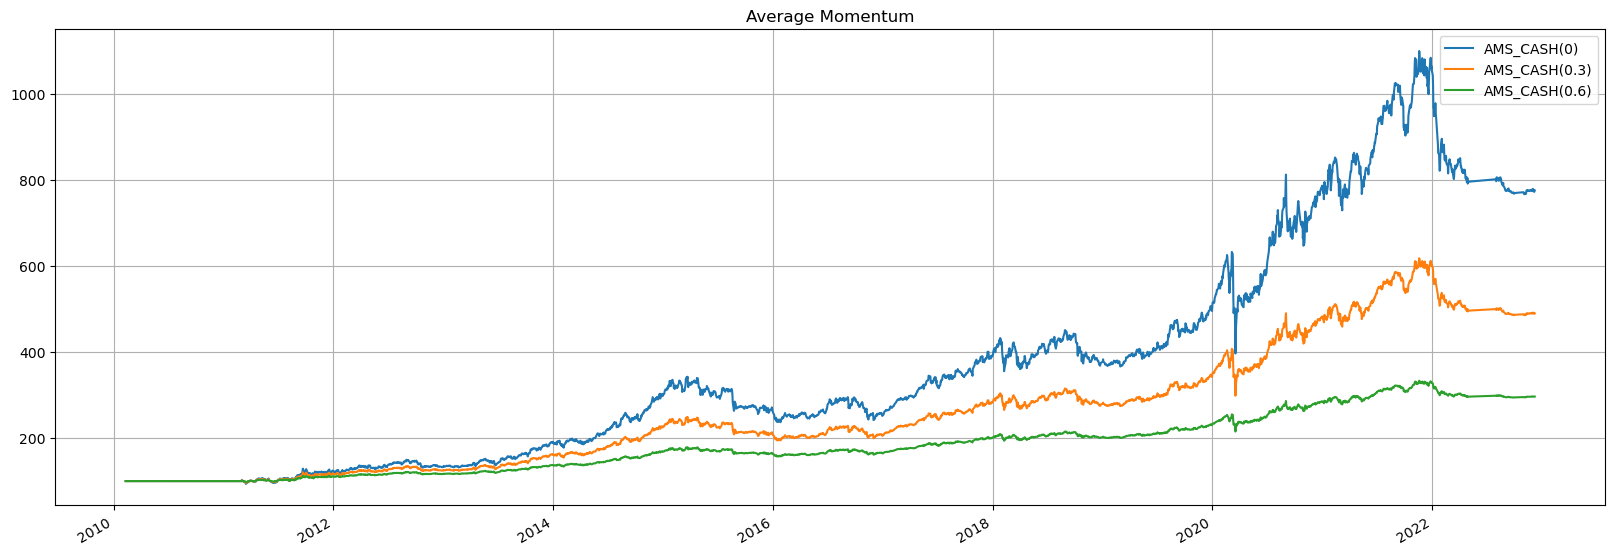

In [7]:
avg_report.plot(figsize=(20,7), grid=True, title='Average Momentum')

In [8]:
avg_report.prices[start_day:].calc_stats().display()

Stat                 AMS_CASH(0)    AMS_CASH(0.3)    AMS_CASH(0.6)
-------------------  -------------  ---------------  ---------------
Start                2011-02-10     2011-02-10       2011-02-10
End                  2022-12-08     2022-12-08       2022-12-08
Risk-free rate       0.00%          0.00%            0.00%

Total Return         675.02%        389.69%          196.26%
Daily Sharpe         0.88           0.93             1.07
Daily Sortino        1.36           1.45             1.67
CAGR                 18.91%         14.38%           9.62%
Max Drawdown         -37.30%        -26.70%          -15.58%
Calmar Ratio         0.51           0.54             0.62

MTD                  -0.36%         -0.23%           -0.10%
3m                   -0.14%         0.13%            0.40%
6m                   -2.83%         -1.53%           -0.24%
YTD                  -26.41%        -18.35%          -9.70%
1Y                   -27.37%        -19.05%          -10.07%
3Y (ann.)           

<AxesSubplot:>

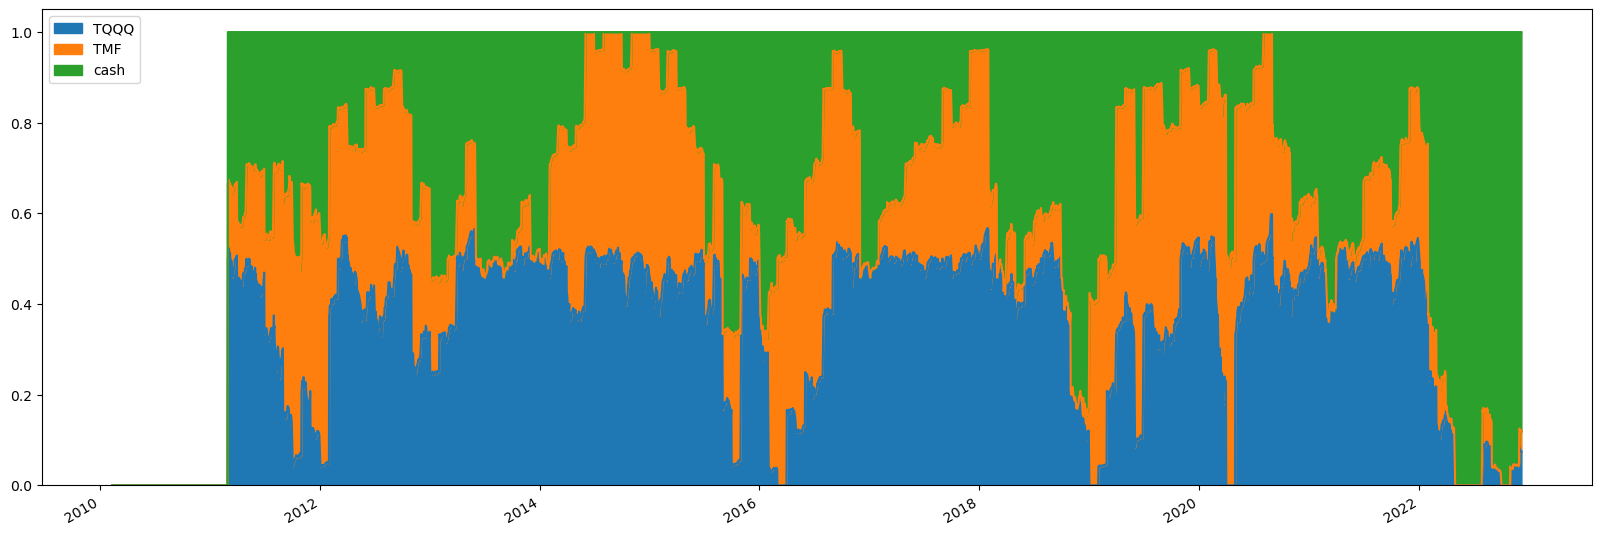

In [9]:
avg_report.get_security_weights().plot.area(figsize=(20,7))

In [15]:
# 수익률곡선+평균모멘텀 스코어 백테스트
def YieldCurveMomentum_BT(assets, months, start_day, run_on_end_of_period=False, lag=1, ylookback=6, name='Yield Curve AMS'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighAMSwithYieldCurve(lookback=months, lag=lag, ylookback=ylookback),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [16]:
assets_cash['yieldcurve'] = avg_report.prices['AMS_CASH(0)'].rebase(1).copy()
yams = YieldCurveMomentum_BT(assets_cash, 12, start_day, False, lag, 6, 'Yield Curve AMS')
yams_report = bt.run(yams)

<AxesSubplot:title={'center':'Yield Curve Momentum'}>

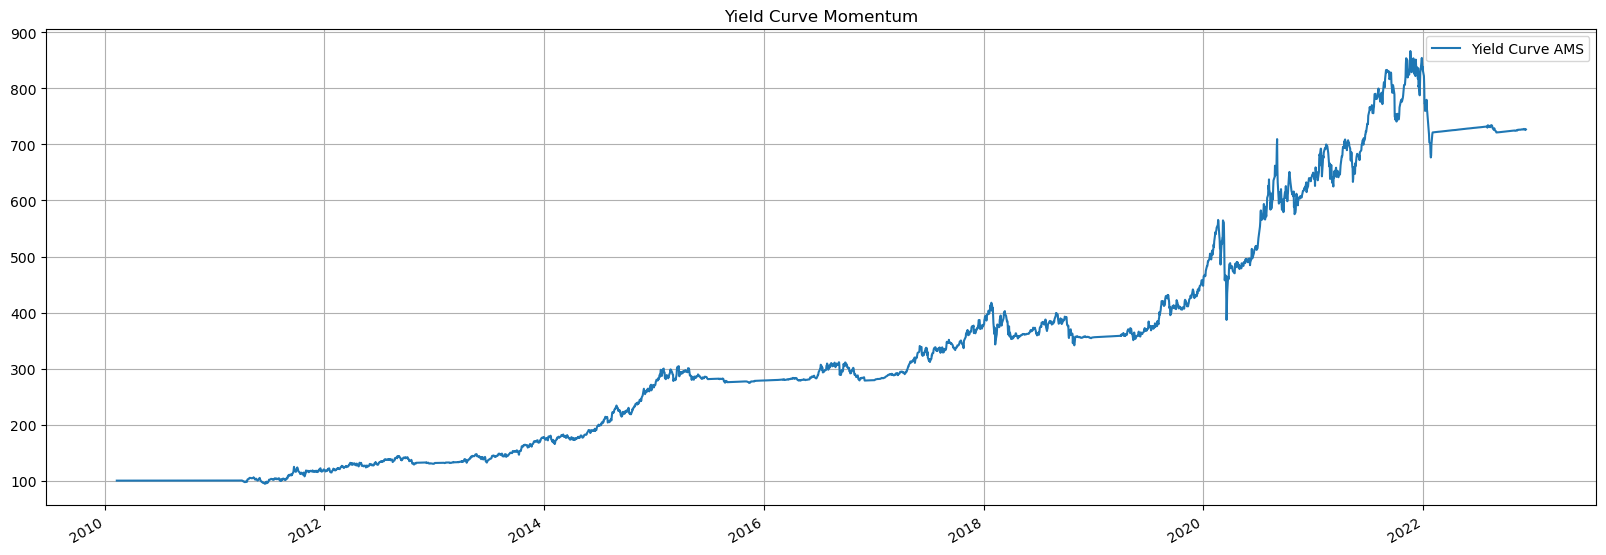

In [17]:
yams_report.plot(figsize=(20,7), grid=True, title='Yield Curve Momentum')

In [18]:
yams_report.prices[start_day:].calc_stats().display()

Stat                 Yield Curve AMS
-------------------  -----------------
Start                2011-02-10
End                  2022-12-08
Risk-free rate       0.00%

Total Return         626.84%
Daily Sharpe         0.98
Daily Sortino        1.50
CAGR                 18.26%
Max Drawdown         -31.57%
Calmar Ratio         0.58

MTD                  -0.08%
3m                   0.72%
6m                   -0.28%
YTD                  -12.51%
1Y                   -13.65%
3Y (ann.)            19.15%
5Y (ann.)            14.48%
10Y (ann.)           18.64%
Since Incep. (ann.)  18.26%

Daily Sharpe         0.98
Daily Sortino        1.50
Daily Mean (ann.)    18.59%
Daily Vol (ann.)     18.91%
Daily Skew           -0.73
Daily Kurt           7.12
Best Day             7.16%
Worst Day            -10.45%

Monthly Sharpe       1.10
Monthly Sortino      2.36
Monthly Mean (ann.)  18.20%
Monthly Vol (ann.)   16.50%
Monthly Skew         0.34
Monthly Kurt         1.42
Best Month           15.86%
Worst M

In [30]:
# 변동성역가중 백테스트(일간데이터)
def WeighInvVol_BT(assets, months, start_day, run_on_end_of_period=False, lag=1, name='Inverse Volatility'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighInvVol(lookback=pd.DateOffset(years=1), lag=pd.DateOffset(days=1)),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [31]:
# 변동성역가중 백테스트(월간 기준)
def WeighInvVol_BT2(assets, months, start_day, run_on_end_of_period=False, lag=1, name='Inverse Volatility'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighInvVol_monthly(lookback=months, lag=lag),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [32]:
# 변동성 역가중(일간, 월간)
invVol_daily = WeighInvVol_BT(assets[tickers], 12, start_day, True, lag, name='Inv Volatility(daily)')
invVol_monthly = WeighInvVol_BT2(assets[tickers], 12, start_day, False, lag, name='Inv Volatility(monthly)')
invVol_report = bt.run(invVol_daily, invVol_monthly)

<AxesSubplot:title={'center':'Inverse Volatility'}>

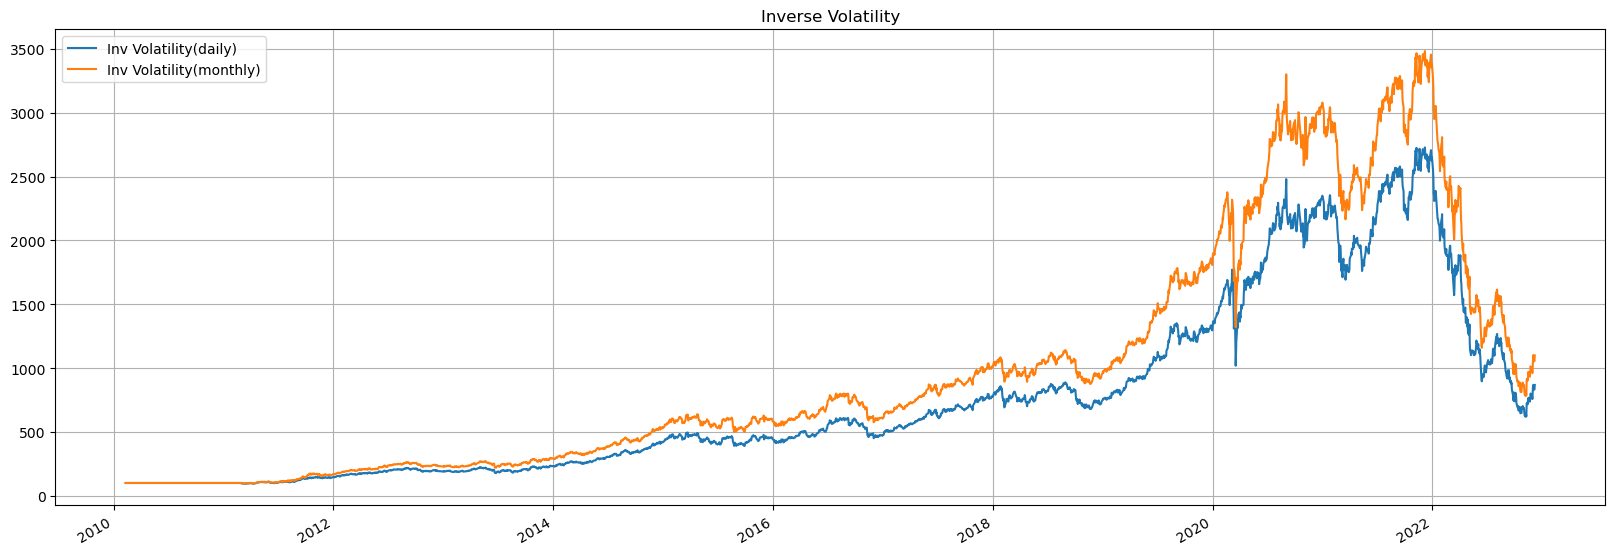

In [33]:
invVol_report.plot(figsize=(20,7), grid=True, title='Inverse Volatility')

In [34]:
#invVol_report.prices[start_day:].calc_stats().display()
invVol_report.set_date_range(start_day)
invVol_report.display()

Stat                 Inv Volatility(daily)    Inv Volatility(monthly)
-------------------  -----------------------  -------------------------
Start                2011-02-10               2011-02-10
End                  2022-12-07               2022-12-07
Risk-free rate       0.00%                    0.00%

Total Return         767.94%                  998.33%
Daily Sharpe         0.75                     0.81
Daily Sortino        1.19                     1.29
CAGR                 20.06%                   22.47%
Max Drawdown         -77.29%                  -77.56%
Calmar Ratio         0.26                     0.29

MTD                  8.22%                    8.42%
3m                   -10.09%                  -10.64%
6m                   -24.25%                  -25.74%
YTD                  -67.01%                  -67.30%
1Y                   -68.18%                  -68.47%
3Y (ann.)            -12.26%                  -14.69%
5Y (ann.)            2.74%                    2.27%
10